In [ ]:
import json
from typing import Dict, List
from openai import OpenAI
import base64
import os

class LLMHandler:
    def __init__(
        self,
        system_prompt: str,
        llm_base_url: str,
        llm_api_key: str,
        classes_dict: Dict[int, str],
        model: str = "gemini-2.5-flash",
        llm_options={},
        **_,
    ):
        self.model = model
        self.client = OpenAI(base_url=llm_base_url, api_key=llm_api_key)
        self.chat_store = []
        self.system_prompt = system_prompt
        self.llm_options = llm_options
        self.classes_dict = classes_dict

    def craft_textual_prompt(self, encoded_images: List[str]) -> str:
        return f"You are given {len(encoded_images)} images. Output your classifications in JSON format, with each image number "\
            "as the key and the corresponding index of the class as the value. Be as precise and specific as possible in your "\
            "classifications. You must only select from the provided classes, and any answer outside this set is incorrect and "\
            "unacceptable. If an object does not belong to any of the specified categories, return -1. "\
            f"Heres the expected output format: {{'1: 0, '2': -1, ..., '{len(encoded_images)}': 'index value'}} \n" \
            "Remember, only output the JSON object with your classifications. Do not include any explanations or" \
            f"additional text. \nClasses (index: label): {json.dumps(self.classes_dict, indent=2)}"


    def classify_entities(self, encoded_images: List[str]):
        # Initialize chat messages with system prompt
        messages = [{"role": "system", "content": self.system_prompt}]

        # Craft user prompt based on input images
        input_text = self.craft_textual_prompt(encoded_images)
        content = [{"type": "text", "text": input_text}]

        # Image input(s)
        for im in encoded_images:
            content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{im}"}
                }
            )
        messages.append({"role": "user", "content": json.dumps(content)})

        print("Querying the model with the following messages:")
        for msg in messages:
            print(f"{msg['role'].upper()}: {msg['content']}")
        # print(f"Expected output schema: {json.dumps(output_schema)}")

        # Query the model
        response = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            response_format={
                "type": "json_object",
            },
            **self.llm_options
        )

        return json.loads(response.choices[0].message.content)


In [ ]:
SYSTEM_PROMPT = """
You are a highly advanced image classification system. You have been trained on a vast array of visual data and can accurately identify objects, scenes, and concepts across a wide range of categories. You will be presented with:
- One *global scene frame* extracted from a video. This frame provides spatial and contextual information about the environment.
- Multiple images for classification. Your task is to analyze each image carefully, considering multiple aspects such as shape, color, texture, context, and any distinguishing features. Draw upon your extensive knowledge and the broader context provided by the full image frame to determine the  most accurate label for each image from the provided set of 10 classes. The objects or region of interest depicted in the images might appear in the provided global scene frame (fully, partially, occluded or from a different perspective), helping with classification.
"""

CLASSES_DICT = {
    0: "floor, ground",
    1: "wall",
    2: "door",
    3: "ceiling, roof",
    4: "window",
    5: "chair",
    6: "table, desk, counter, working surface",
    7: "bottle",
    8: "WD-40 can",
    9: "person, human",
}


API_KEY="..."
BASE_URL="https://generativelanguage.googleapis.com/v1beta/openai/"


In [ ]:
llm_handler = LLMHandler(
    system_prompt=SYSTEM_PROMPT,
    llm_base_url=BASE_URL,
    llm_api_key=API_KEY,
    classes_dict=CLASSES_DICT,
)


In [ ]:
# Function to encode the images
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

visual_prompts_dir = "/home/amiuser/repos/entitysam/output_w_imgs/vit-l_robot_logger_device_2025_03_31_17_14_28_interval_frames/entity_prompts"
scene_frame_path = "/home/amiuser/repos/entitysam/data/robot_logger_device_2025_03_31_17_14_28_interval_frames/frame_0000.jpg"

# Encode the scene frame
encoded_images = [encode_image(scene_frame_path)]
# Encode all images in the visual prompts directory
image_paths = [os.path.join(visual_prompts_dir, f) for f in os.listdir(visual_prompts_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
encoded_images.extend(encode_image(p) for p in image_paths)


Querying the model with the following messages:
SYSTEM: 
You are a highly advanced image classification system. You have been trained on a vast array of visual data and can accurately identify objects, scenes, and concepts across a wide range of categories. You will be presented with:
- One *global scene frame* extracted from a video. This frame provides spatial and contextual information about the environment.
- Multiple images for classification. Your task is to analyze each image carefully, considering multiple aspects such as shape, color, texture, context, and any distinguishing features. Draw upon your extensive knowledge and the broader context provided by the full image frame to determine the  most accurate label for each image from the provided set of 10 classes. The objects or region of interest depicted in the images might appear in the provided global scene frame (fully, partially, occluded or from a different perspective), helping with classification.

USER: [{"type": "tex
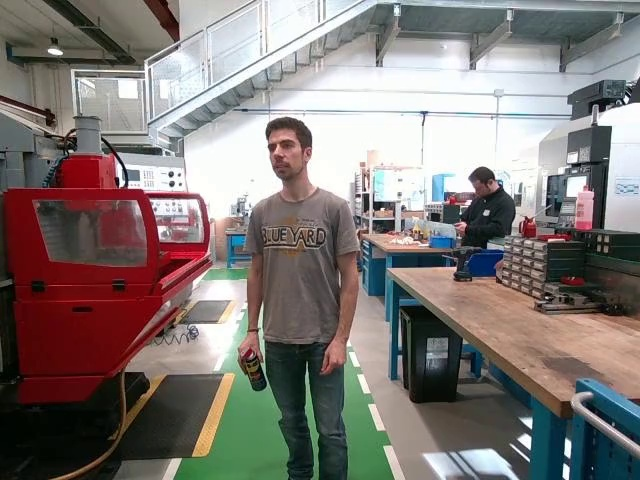
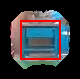
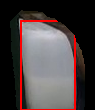
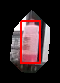
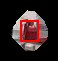
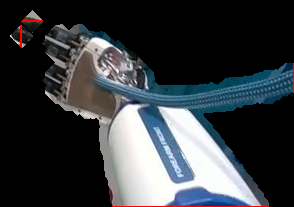
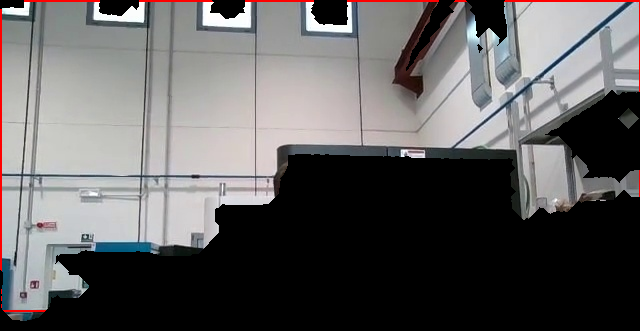
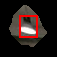
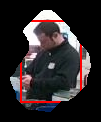
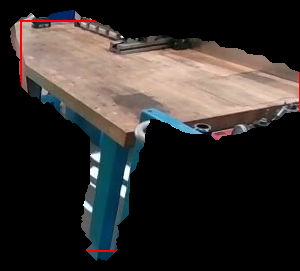
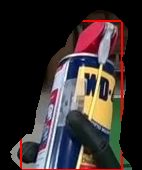
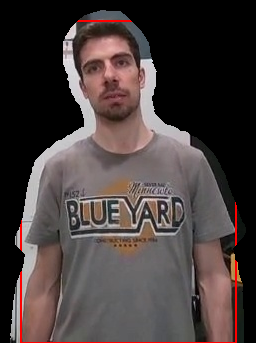
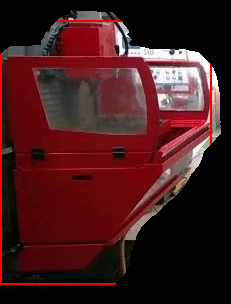
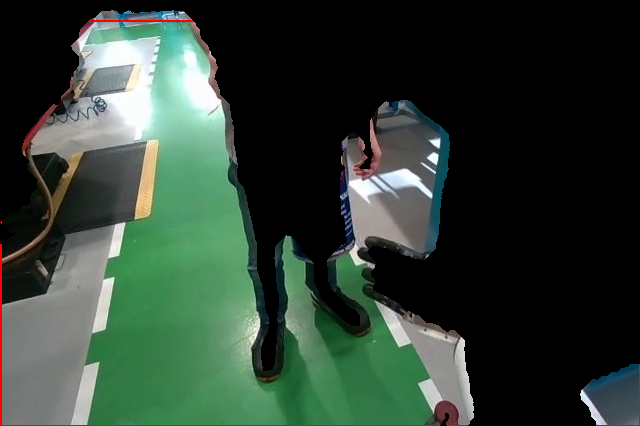
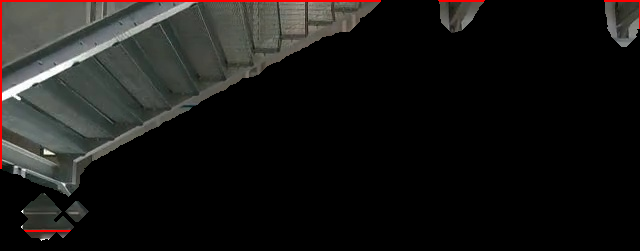
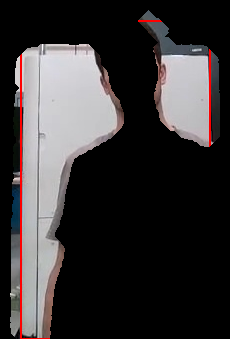

RateLimitError: Error code: 429 - [{'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 250000\nPlease retry in 20.969979496s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_input_token_count', 'quotaId': 'GenerateContentInputTokensPerModelPerMinute-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '250000'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '20s'}]}}]

In [ ]:
# Classify the encoded images
results = llm_handler.classify_entities(encoded_images)
print(results)
